#Introduction

The aim of this project is to predict the protein family ([Pfam](https://https://en.wikipedia.org/wiki/Pfam) family) based on the protein amino-acid sequence.

It is a long standing problem in molecular biology, which has received a lot of renewed attention recently. The main idea of the most successful recent approaches is to apply deep learning models, especially developed for NLP tasks, such as CNN [1, 2], Transformer [3, 4] and  bidirectional LSTM [5].

In this project we employ the model developed in Ref.[5].

References:

1. "Using Deep Learning to Annotate the Protein Universe", M.L. Bileschi et.al., Nature Biotechnology, 40, 932–937 (2022), https://doi.org/10.1101/626507

2. "Convolutions are competitive with transformers for protein sequence pretraining", K K. Yang et. al., https://doi.org/10.1101/2022.05.19.492714

3. "Transforming the Language of Life: Transformer Neural Networks for Protein Prediction Tasks",
A. Nambiar, BCB '20: Proceedings of the 11th ACM International Conference on Bioinformatics, Computational Biology and Health Informatics, Article No.: 5, 1-8, (2020), https://doi.org/10.1145/3388440.3412467
4.  "Transformer Neural Networks Attending to BothSequence and Structure for Protein Prediction Tasks", A. Kabir and A. Shehu, https://arxiv.org/pdf/2206.11057.pdf
5. "Learning the protein language: Evolution, structure, and function", T. Bepler and B. Berger, Cell Systems 12, 654–669, (2021), https://doi.org/10.1016/j.cels.2021.05.017


#Get data from Kaggle

In [ ]:
# by default the notebook runs on google colab
# if it's not the case, you should change the way of getting data

In [ ]:
! pip install -q kaggle

In [ ]:
# download kaggle.json file from google drive
# !gdown 1juGKEqeiJLjOq5kcx6zGVZ96vPWy6iKc

Downloading...
From: https://drive.google.com/uc?id=1juGKEqeiJLjOq5kcx6zGVZ96vPWy6iKc
To: /content/kaggle.json
100% 72.0/72.0 [00:00<00:00, 90.6kB/s]


In [ ]:
# # upload your kaggle.json file from local files
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download googleai/pfam-seed-random-split
! unzip pfam-seed-random-split.zip

 99% 489M/493M [00:05<00:00, 87.2MB/s]
100% 493M/493M [00:05<00:00, 93.1MB/s]
Archive:  pfam-seed-random-split.zip
  inflating: random_split/dev/data-00000-of-00010  
  inflating: random_split/dev/data-00001-of-00010  
  inflating: random_split/dev/data-00002-of-00010  
  inflating: random_split/dev/data-00003-of-00010  
  inflating: random_split/dev/data-00004-of-00010  
  inflating: random_split/dev/data-00005-of-00010  
  inflating: random_split/dev/data-00006-of-00010  
  inflating: random_split/dev/data-00007-of-00010  
  inflating: random_split/dev/data-00008-of-00010  
  inflating: random_split/dev/data-00009-of-00010  
  inflating: random_split/random_split/dev/data-00000-of-00010  
  inflating: random_split/random_split/dev/data-00001-of-00010  
  inflating: random_split/random_split/dev/data-00002-of-00010  
  inflating: random_split/random_split/dev/data-00003-of-00010  
  inflating: random_split/random_split/dev/data-00004-of-00010  
  inflating: random_split/random_split/d

Import libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Read data

In [ ]:
data_path = 'random_split' 
print('Available data', os.listdir(data_path))

def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(data_path, partition)):
    with open(os.path.join(data_path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)

# creating train, validation and test DataFrames
df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')
df_train.head()

Available data ['test', 'random_split', 'dev', 'train']


,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,Ribosomal_S3_C,I7HEJ8_9HELI/120-202,PF00189.20,IATQLEKRVAFRRAMKKVMQAAM.K......A.G..AKGIKVKVSG...,IATQLEKRVAFRRAMKKVMQAAMKAGAKGIKVKVSGRLAGAEMART...
1,DUF2114,A3CU80_METMJ/40-497,PF09887.9,PYFIVASVEMGNTTTKCILTGTNLETGRSYVINKTVTMSRDVRPPK...,PYFIVASVEMGNTTTKCILTGTNLETGRSYVINKTVTMSRDVRPPK...
2,Coprogen_oxidas,K4IEE8_PSYTT/5-300,PF01218.18,.FYNYIQNLQDTITSK.LESVD.......................G...,FYNYIQNLQDTITSKLESVDGTATFFEDIWERKEGGGGRTRVIENG...
3,Flavokinase,A0A212EJD8_DANPL/6-132,PF01687.17,..LPLFLKGQVVNGFGR.GSKD.L.........GCPTA......NF...,LPLFLKGQVVNGFGRGSKDLGCPTANFPREVAQSLPKDLKTGVYYG...
4,TFR_dimer,A2BGQ8_DANRE/619-737,PF04253.15,ISMESLKKAVQFFRDTATKLDRLIRD.SD....................,ISMESLKKAVQFFRDTATKLDRLIRDSDLVKETPLKARRINDQLML...


#Exploratory data analysis

In [ ]:
# create dictionary with all three sets
df_sets = {'train': df_train, 'validation': df_val, 'test': df_test}

####Sets sizes

In [ ]:
total_len = sum(len(df_set) for df_set in df_sets.values())  # total length 
for set_name, df_set in df_sets.items():
  print(f'The size of the {set_name} set is {len(df_set)}, which is {len(df_set)/total_len * 100:.1f}% of the total available data')

The size of the train set is 1086741, which is 81.2% of the total available data
The size of the validation set is 126171, which is 9.4% of the total available data
The size of the test set is 126171, which is 9.4% of the total available data


####Distribution of sequence lengths

In [ ]:
# Length of sequences

for set_name, df_set in df_sets.items():
  df_set['sequence_length'] = df_set.sequence.apply(len)
  print(set_name, df_set['sequence_length'].describe(),'\n')

train count    1.086741e+06
mean     1.553800e+02
std      1.201232e+02
min      4.000000e+00
25%      7.600000e+01
50%      1.190000e+02
75%      1.950000e+02
max      2.037000e+03
Name: sequence_length, dtype: float64 

validation count    126171.000000
mean        154.222206
std         118.278250
min           9.000000
25%          76.000000
50%         118.000000
75%         194.000000
max        1971.000000
Name: sequence_length, dtype: float64 

test count    126171.000000
mean        154.166845
std         118.376706
min           9.000000
25%          76.000000
50%         118.000000
75%         194.000000
max        1937.000000
Name: sequence_length, dtype: float64 



Plot distribution of sequence length for each set

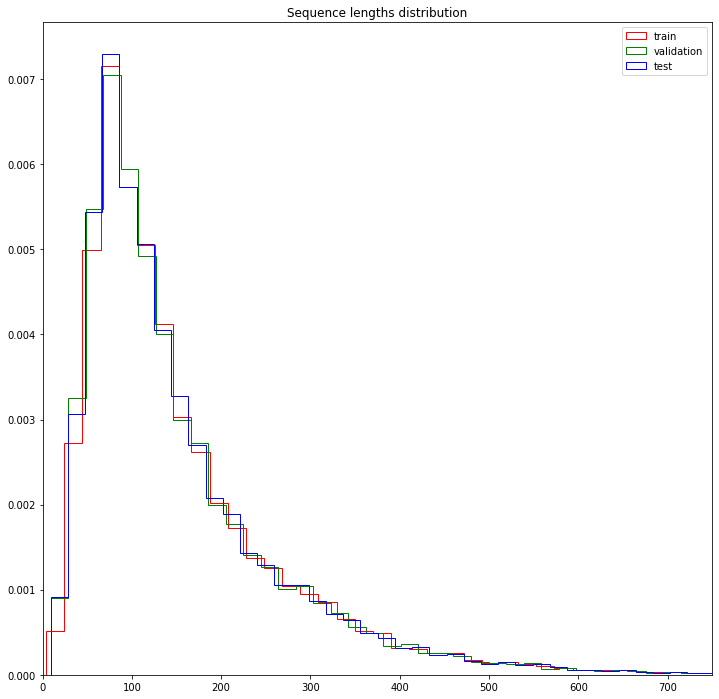

In [ ]:
plt.figure(figsize=(12, 12))
plt.title('Sequence lengths distribution')
colors = ['r','g', 'b'] 
for ind, (set_name, df_set) in enumerate(df_sets.items()):
   plt.hist(df_set['sequence_length'], density=True, bins=100, label=set_name, histtype='step', color=colors[ind])
plt.legend()   
plt.xlim(0,750)
plt.show()

##Conclusion: the core of the distribution of sequence lengths looks the same for all three sets. At the same time, the distribution for the train set has a long tail, which changes significantly the mean value, the standard deviation and higher moments compared to the distributions for validation and test sets.  

###Statistics of labels: family_accession	

In [ ]:
for set_name, df_set in df_sets.items():
  print(set_name, df_set['family_accession'].describe(),'\n')

train count       1086741
unique        17929
top       PF13649.6
freq           3637
Name: family_accession, dtype: object 

validation count        126171
unique        13071
top       PF13649.6
freq            454
Name: family_accession, dtype: object 

test count        126171
unique        13071
top       PF13649.6
freq            454
Name: family_accession, dtype: object 



#### Train set contains much more label classes than test and validation sets 

In [ ]:
# check that all classes in test/validation sets are contained in test set
print(set(df_test['family_accession'].values).difference(set(df_train['family_accession'])))
print(set(df_val['family_accession'].values).difference(set(df_train['family_accession'])))

set()
set()


####Statistics of the most frequent labels in each class

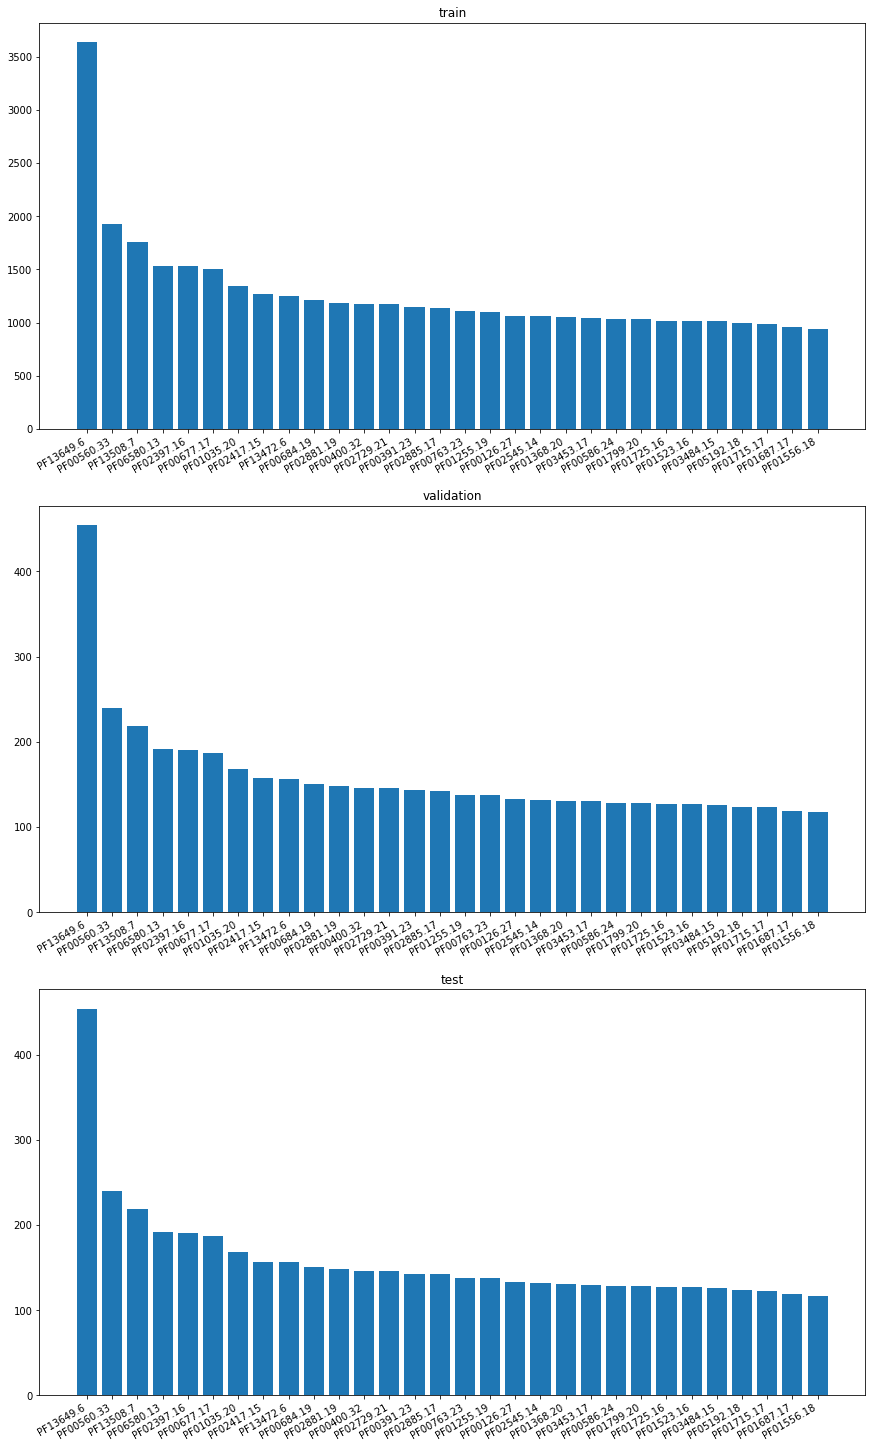

In [ ]:
num_labels = 30
axs = plt.figure(figsize=(12, 20), constrained_layout=True).subplots(3, 1)
label_counts_dict = {}
for ax, (set_name, df_set) in zip(axs.flat, df_sets.items()):
    ax.set_title(set_name)
    label_counts = df_set.family_accession.value_counts()[:num_labels]
    label_counts_dict[set_name] = label_counts
    ax.bar(label_counts.index, label_counts.values)
    plt.draw()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()

The least frequent labels in the trai set and their counts

In [ ]:
df_train.family_accession.value_counts()[-10:]

PF18245.1     1
PF17610.2     1
PF05248.12    1
PF07188.11    1
PF15641.6     1
PF17879.1     1
PF01692.18    1
PF12233.8     1
PF16430.5     1
PF11685.8     1
Name: family_accession, dtype: int64

Check whether the most frequent labels are the same in all sets

In [ ]:
print(label_counts_dict['train'].index == label_counts_dict['test'].index)
print(label_counts_dict['validation'].index == label_counts_dict['test'].index)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False  True  True  True  True  True  True  True
  True  True  True  True  True  True]


It looks like the most frequent labels are not exactly the same for different sets. Let's look at it more carefully.

In [ ]:
print(set(label_counts_dict['train'].index) == set(label_counts_dict['test'].index))
print(set(label_counts_dict['validation'].index) == set(label_counts_dict['test'].index))

True
True


In [ ]:
print(label_counts_dict['train'][label_counts_dict['train'].index != label_counts_dict['test'].index])
print(label_counts_dict['test'][label_counts_dict['validation'].index != label_counts_dict['test'].index])

Series([], Name: family_accession, dtype: int64)
PF00763.23    138
PF01255.19    138
Name: family_accession, dtype: int64


Conclusion: the apparent difference in the labels order is due to the fact that some of them have exactly the same counts.  

####Statistics of label frequencies

In [ ]:
for set_name, label_counts in label_counts_dict.items():
  print(set_name, (label_counts / label_counts.sum()).describe(),'\n')

train count    30.000000
mean      0.033333
std       0.013257
min       0.024521
25%       0.027014
50%       0.029454
75%       0.033020
max       0.095180
Name: family_accession, dtype: float64 

validation count    30.000000
mean      0.033333
std       0.013289
min       0.024580
25%       0.026891
50%       0.029412
75%       0.032931
max       0.095378
Name: family_accession, dtype: float64 

test count    30.000000
mean      0.033333
std       0.013289
min       0.024580
25%       0.026891
50%       0.029412
75%       0.032931
max       0.095378
Name: family_accession, dtype: float64 



##Conclusions:

1. The train set contains much more label classes than test and validation sets.

2. All label classes from test/validation sets are present in the train set.

3. The statistics of the most frequent labels is the same in all three sets.

4. Different classes are highly inbalanced with number of counts ranging from 1 to 3637 in the train set.

5. In order to construct a reliable model one needs to eliminate the classes with small number of counts and compensate for classes inbalance.




####Keep only labels with a high number of counts

In [ ]:
# identify labels with the number of counts > min_counts in the train set
min_counts = 1000 
train_label_counts = df_train.family_accession.value_counts().to_dict()
frequent_labels = [labels for labels, counts in train_label_counts.items() if counts > min_counts]

# alternatively pick up a certain number of classes
# class_num = 50
class_num = 100
frequent_labels = list(train_label_counts.keys())[:class_num]

# restrict all three sets by selecting only these labels

for set_name, df_set in df_sets.items():
  df_sets[set_name] = df_set[df_set.family_accession.isin(frequent_labels)].copy()
  print(f'Length of the reduced {set_name} set: {len(df_sets[set_name])}')
print(f'Number of classes: {len(frequent_labels)}')  

Length of the reduced train set: 92983
Length of the reduced validation set: 11565
Length of the reduced test set: 11565
Number of classes: 100


###Data preprocessing 

In [ ]:
# reduce the total number of samples for reducing RAM and faster training
# max_train_len = 1000
# max_test_len = 200

max_train_len = 10000
max_test_len = 2000

df_sets['train'] = df_sets['train'][:max_train_len]
frequent_labels = df_sets['train'].family_accession.unique()
print(f'Number of classes: {len(frequent_labels)}')  

df_sets['test'] = df_sets['test'][df_sets['test'].family_accession.isin(frequent_labels)][:max_test_len].copy()
df_sets['validation'] = df_sets['validation'][df_sets['validation'].family_accession.isin(frequent_labels)][:max_test_len].copy()

# one-hot encoding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(np.asarray(frequent_labels).reshape(-1,1))

onehot_labels = {set_name: encoder.transform(df_set.family_accession.values.reshape(-1,1)) for set_name, df_set in df_sets.items()}

Number of classes: 100


#Model

In this section we employ the model developed in "Learning the protein language: Evolution, structure, and function" by T. Bepler and B. Berger, Cell Systems 12, 654–669, (2021),
https://doi.org/10.1016/j.cels.2021.05.017 .

The main idea of this wotk is to employ the multi-task learning technique combining self-supervision on a large amount of protein sequence data with structure supervision on a smaller set of data. In this way, the learned vector representation of proteins can improve solution of downstream problems, such as protein function prediction, through transfer learning.  


####Importing trained model

In [ ]:
# to employ the model from the paper we copy the coresponding repositry 
# to a local folder, as it is done in https://www.kaggle.com/code/yassermhbh/pfam-ml-part2
!git clone https://github.com/tbepler/prose.git
!wget -nc -P prose/ http://bergerlab-downloads.csail.mit.edu/prose/saved_models.zip
!unzip -q -n prose/saved_models.zip -d prose/

Cloning into 'prose'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 26 (delta 1), reused 23 (delta 1), pack-reused 0
Unpacking objects: 100% (26/26), done.
--2022-09-13 11:38:45--  http://bergerlab-downloads.csail.mit.edu/prose/saved_models.zip
Resolving bergerlab-downloads.csail.mit.edu (bergerlab-downloads.csail.mit.edu)... 128.30.48.147
Connecting to bergerlab-downloads.csail.mit.edu (bergerlab-downloads.csail.mit.edu)|128.30.48.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 581846360 (555M) [application/zip]
Saving to: ‘prose/saved_models.zip’

saved_models.zip    100%[===================>] 554.89M  80.9MB/s    in 7.0s    

2022-09-13 11:38:52 (79.4 MB/s) - ‘prose/saved_models.zip’ saved [581846360/581846360]



In [ ]:
!pip install -r prose/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 3.1 MB 4.8 MB/s 
     |████████████████████████████████| 169.1 MB 69 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.8.1+cpu which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.8.1+cpu which is incompatible.
torchaudio 0.12.1+cu113 req

Write train, test and validation data into models data files

In [ ]:
# create dictionaries {sequence_name: sequence} for all sets

seq_dicts = {set_name: dict(zip(df_set.sequence_name, df_set.sequence)) for set_name, df_set in df_sets.items()}

# write sequences from sets into the corresponding fasta files of the model
for set_name, seq_dict in seq_dicts.items():
  with open(f'prose/data/{set_name}_domains.fa','w') as f:
    for seq_name, seq in seq_dict.items():
      f.write('>' + seq_name.replace('/','@') + '\n')
      f.write(seq + '\n')



####Create embeddings 
Transform our data features into embeding vectors using the pre-trained model.

*This is a very slow process, see below for details.*  
*If you want to use it, uncommnet the cell below, otherwise proceed to the next cell.*

In [ ]:
# import time
# start = time.time()
# !python3 prose/embed_sequences.py --pool avg -o prose/data/train_domains.h5 prose/data/train_domains.fa
# !python3 prose/embed_sequences.py --pool avg -o prose/data/validation_domains.h5 prose/data/validation_domains.fa
# !python3 prose/embed_sequences.py --pool avg -o prose/data/test_domains.h5 prose/data/test_domains.fa
# end = time.time()
# print(f'Execution time: {end - start} seconds')

CPU:
10 classes, train_len = 1000,  Execution time: 1390.7974519729614 seconds

50 classes, train_len = 1000, Execution time: 1216.1450662612915 seconds

100 classes, train_len = 10000, Execution time: 16334.530764818192 seconds > 4.5 hours!

\

GPU:
5 classes, train_len = 1000
Execution time: 794.8291540145874 seconds

10 classes, train_len = 1000 Execution time: 839.9239826202393 seconds

####Download embeddings calculated before 

*Comment three cells below, if you have already calculated embedding using the cell above*

In [ ]:
!pip install gdown -U --no-cache-dir
import gdown
url = 'https://drive.google.com/drive/folders/12rqql8Va6mQh91wit1JreIP8KArwcUyH'

gdown.download_folder(url)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14951 sha256=5f8e1fe0dae3507e8729463f0e9d5dc5fa29f7050123f17a33207c3e0cbd3393
  Stored in directory: /tmp/pip-ephem-wheel-cache-xx0rlcwb/wheels/3d/ec/b0/a96d1d126183f98570a785e6bf8789fca559853a9260e928e1
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


Retrieving folder list


Retrieving folder 1Fd3bpRZZoiTMRZRvtg5JJ1EqdPHzoorP Train_len=1000_num_classes=50
Processing file 1fvCx6TifB9i5m5qKJIREAWXy1ITztGCc test_domains.h5
Processing file 1JVMEr7UKbcGDcuIS5f8gyvVfbuakaVAk train_domains.h5
Processing file 1NrU_RuNHF_fYAZZD6rYmptAQ6Y76x_LH validation_domains.h5
Retrieving folder 1pxeJzlC2IDFkEY_u5fvoOCvY4W__BkU9 Train_len=10000_num_classes=100
Processing file 1nH3qrHRE4lwt5X_5C-NjNQSpOB6GRyj7 test_domains.h5
Processing file 1z6hHLkLwYwctwQNtOyK9YRT5iEMxZqWz train_domains.h5
Processing file 1qqZ3Xq8Q1uuY-jOrxchlOJc1wHoJq5q8 validation_domains.h5
Processing file 1juGKEqeiJLjOq5kcx6zGVZ96vPWy6iKc kaggle.json
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1fvCx6TifB9i5m5qKJIREAWXy1ITztGCc
To: /content/Pfam_classification_data/Train_len=1000_num_classes=50/test_domains.h5
100%|██████████| 5.01M/5.01M [00:00<00:00, 35.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JVMEr7UKbcGDcuIS5f8gyvVfbuakaVAk
To: /content/Pfam_classification_data/Train_len=1000_num_classes=50/train_domains.h5
100%|██████████| 25.1M/25.1M [00:00<00:00, 78.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NrU_RuNHF_fYAZZD6rYmptAQ6Y76x_LH
To: /content/Pfam_classification_data/Train_len=1000_num_classes=50/validation_domains.h5
100%|██████████| 5.01M/5.01M [00:00<00:00, 37.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nH3qrHRE4lwt5X_5C-NjNQSpOB6GRyj7
To: /content/Pfam_classification_data/Train_len=10000_num_classes=100/test_domains.h5
100%|██████████| 50.1M/50.1M [00:00<00:00, 70.4MB/s]
Downloading...
From: https://drive.go

['/content/Pfam_classification_data/Train_len=1000_num_classes=50/test_domains.h5',
 '/content/Pfam_classification_data/Train_len=1000_num_classes=50/train_domains.h5',
 '/content/Pfam_classification_data/Train_len=1000_num_classes=50/validation_domains.h5',
 '/content/Pfam_classification_data/Train_len=10000_num_classes=100/test_domains.h5',
 '/content/Pfam_classification_data/Train_len=10000_num_classes=100/train_domains.h5',
 '/content/Pfam_classification_data/Train_len=10000_num_classes=100/validation_domains.h5',
 '/content/Pfam_classification_data/kaggle.json']

In [ ]:
## copy files to model data folder
## for train_len = 1000
# !rm /content/prose/data/*.h5
# !cp /content/Pfam_classification_data/Train_len=1000_num_classes=50/* /content/prose/data/

## for train_len = 10000
!rm /content/prose/data/*.h5
!cp /content/Pfam_classification_data/Train_len=10000_num_classes=100/* /content/prose/data/


Restore sets from h5 files if required

In [ ]:
restore_sets_from_h5 = True
# restore_sets_from_h5 = False

if restore_sets_from_h5:
  df_train = read_data('train')
  df_val = read_data('dev')
  df_test = read_data('test')

  df_sets = {'train': df_train, 'validation': df_val, 'test': df_test}

  import h5py
  embedding_sets = {}
  for set_name in df_sets:
    hf = h5py.File(f'prose/data/{set_name}_domains.h5', 'r')
    seq_names = [x.replace('@','/') for x in hf]
    df_sets[set_name] = df_sets[set_name][df_sets[set_name].sequence_name.isin(seq_names)].copy()
    df_sets[set_name]['sequence_length'] = df_sets[set_name].sequence.apply(len)

  frequent_labels = df_sets['train'].family_accession.unique()
  seq_dicts = {set_name: dict(zip(df_set.sequence_name, df_set.sequence)) for set_name, df_set in df_sets.items()}
  encoder.fit(np.asarray(frequent_labels).reshape(-1,1))
  onehot_labels = {set_name: encoder.transform(df_set.family_accession.values.reshape(-1,1)) for set_name, df_set in df_sets.items()}

Read the embeddings from files

In [ ]:
import h5py
embedding_sets = {}
for set_name, seq_dict in seq_dicts.items():
  hf = h5py.File(f'prose/data/{set_name}_domains.h5', 'r')
  embedding = {x: np.array(hf[x.replace('/','@')]) for x in seq_dict.keys() if x.replace('/','@') in hf}
  embedding_sets[set_name] = np.vstack(list(embedding.values()))


### Protein function classification model

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


# simple NN model with a single hidden layer
def build_model(input_shape):
    
    X_in = Input(shape=input_shape)
    H = Dense(500, use_bias=True, activation='swish', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3))(X_in)
    H = Dropout(0.4)(H)
    Y = Dense(len(frequent_labels), activation='softmax')(H)

    _model = Model(inputs=[X_in], outputs=Y)
    _model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))
    _model.summary()
    
    return _model

####Train and validate model

####Class weights

As we deal with inbalanced classes it makes sense to balance them by introducing class weights depending on label frequencies.

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = sorted(frequent_labels),
                                                  y = sorted(df_sets['train'].family_accession.values))
class_weights_dict = dict(enumerate(class_weights))


Train model

In [ ]:
from tqdm.keras import TqdmCallback

X_train, y_train = embedding_sets['train'], onehot_labels['train'] 
X_valid, y_valid = embedding_sets['validation'], onehot_labels['validation']
X_test, y_test = embedding_sets['test'], onehot_labels['test']

model = build_model(X_train.shape[1])
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                    batch_size=50, epochs=50, verbose=0, class_weight=class_weights_dict, 
                    callbacks=[TqdmCallback(verbose=2)])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6165)]            0         
                                                                 
 dense (Dense)               (None, 500)               3083000   
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               50100     
                                                                 
Total params: 3,133,100
Trainable params: 3,133,100
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


0epoch [00:00, ?epoch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

  0%|          | 0.00/200 [00:00<?, ?batch/s]

Plot loss evolution

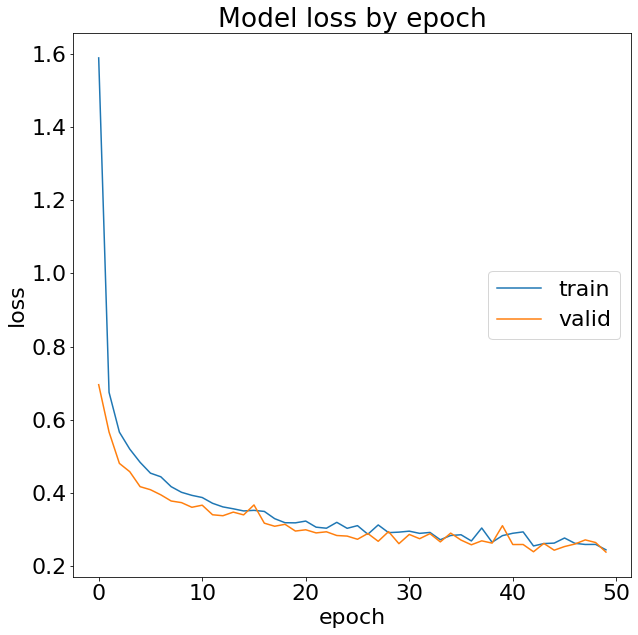

In [ ]:
def plot_train_val_loss(history):
  plt.figure(figsize=(10,10))
  plt.rcParams.update({'font.size': 22})
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss by epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='right')
  plt.savefig('tf_trainvalcurve_scr_classificaiton.svg')

  
plot_train_val_loss(history)

#Predicitons

Accuracy and balanced accuracy

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, balanced_accuracy_score
prob_prediction = model.predict(X_test)
prediction =  np.argmax(prob_prediction, axis=1) 
y_true = np.argmax(y_test, axis=1) 

accuracy = accuracy_score(y_true, prediction)
print(f'Accuracy for the test set for all classes: {accuracy}')

balanced_accuracy = balanced_accuracy_score(y_true, prediction)
print(f'Balanced accuracy for the test set for all classes: {balanced_accuracy}')

Accuracy for the test set for all classes: 0.9795
Balanced accuracy for the test set for all classes: 0.9768644276280921


For train_len = 1000, test_len = 200, num_classes = 50

Accuracy for the test set for all classes: 0.99\
Balanced accuracy for the test set for all classes: 0.992

\

For train_len = 10000, test_len = 2000, num_classes = 100

ccuracy for the test set for all classes: 0.980\
Balanced accuracy for the test set for all classes: 0.977

Precision, recall, F1

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def get_performance(y_true, prediction):
  df_performance = pd.DataFrame([], index=('micro', 'balanced'), columns=['accuracy', 'precision', 'recall', 'f1'])

  accuracy = accuracy_score(y_true, prediction)
  precision, recall, f1, _ = precision_recall_fscore_support(y_true, prediction, average='micro')
  df_performance.loc['micro', :] = (accuracy, precision, recall, f1)

  accuracy_b = balanced_accuracy_score(y_true, prediction)
  precision_b, recall_b, f1_b, _ = precision_recall_fscore_support(y_true, prediction, average='weighted')
  df_performance.loc['balanced', :] = (accuracy_b, precision_b, recall_b, f1_b)
  
  return df_performance

df_performance = get_performance(y_true, prediction)
print(df_performance)

          accuracy precision  recall        f1
micro       0.9795    0.9795  0.9795    0.9795
balanced  0.976864  0.982565  0.9795  0.979902


Confusion matrix

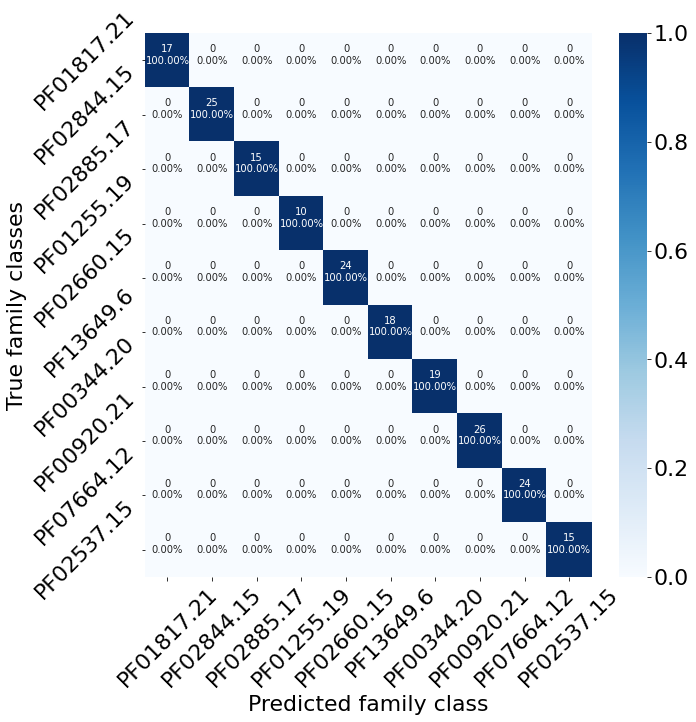

In [ ]:
def plot_conf_matrix(prediction, y_true, num_classes):
  num_classes = min(num_classes, len(frequent_labels))
  top_labels = frequent_labels[:num_classes]

  df_sets['test']['y_test'] = y_true
  df_sets['test']['test_preds'] = prediction

  df_test_top = df_sets['test'][df_sets['test']['y_test'].isin(range(num_classes)) & df_sets['test']['test_preds'].isin(range(num_classes))]
  df_test_top.reset_index(inplace=True)

  y_test = df_test_top.y_test.to_numpy()
  test_preds = df_test_top.test_preds.to_numpy()

  cf_matrix = confusion_matrix(y_test, test_preds)
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]

  cf_matrix_percentage = cf_matrix/cf_matrix.sum(axis=1)[:,None]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix_percentage.flatten()]

  labels = [f"{v1}\n{v2}\n" for v1, v2 in
            zip(group_counts, group_percentages)]

  labels = np.asarray(labels).reshape(len(cf_matrix), len(cf_matrix)) 

  fig, ax = plt.subplots(figsize=(10, 10))
  sns.heatmap(cf_matrix_percentage, annot=labels, fmt='', cmap='Blues', ax=ax, vmin=0, vmax=1, annot_kws={'fontsize': 10})

  ax.set_xlabel('Predicted family class')
  ax.set_ylabel('True family classes');
  ax.xaxis.set_ticklabels(top_labels, rotation=45)
  ax.yaxis.set_ticklabels(top_labels, rotation=45)

plot_conf_matrix(prediction, y_true, 10)

The prediction results are so good that we want to be sure that the most data in the test set is unseen.

In [ ]:
unseen_frac = len(set(df_sets['test'].sequence) - set(df_sets['train'].sequence)) / len(set(df_sets['test'].sequence))
print(f'The faction of unseen data in the test set is {unseen_frac  * 100:.2f}% of the total available data')

The faction of unseen data in the test set is 99.90% of the total available data


####Accuracy as a function of sequence length

In [ ]:
def get_acccuracy_intervals(y_true,  prediction):
  df_temp = df_sets['test']
  df_temp['y_test'] = y_true
  df_temp['prediction'] = prediction
  bins = 10
  intervals = pd.qcut(df_temp['sequence_length'], bins, duplicates='drop') 
  intervals_unique = intervals.unique().sort_values() 
  intervals_accuracy = []

  for interval in intervals_unique:
    index = df_temp.index.intersection(intervals[intervals == interval].index)
    acc = accuracy_score(df_temp.loc[index, 'y_test'], df_temp.loc[index, 'prediction'])
    intervals_accuracy.append(acc)

  df_accuracy_intervals = pd.DataFrame(intervals_accuracy, index=pd.Index(intervals_unique, name='sequence_length'), columns=['accuracy'])

  return df_accuracy_intervals

df_accuracy_intervals = get_acccuracy_intervals(y_true,  prediction)
print(df_accuracy_intervals)

                 accuracy
sequence_length          
(18.999, 61.0]   0.991342
(61.0, 75.0]     0.970213
(75.0, 84.0]     0.975962
(84.0, 94.0]     0.980296
(94.0, 110.0]    0.964758
(110.0, 124.0]   0.977169
(124.0, 149.3]   0.980488
(149.3, 184.0]   0.986425
(184.0, 249.0]   0.986239
(249.0, 614.0]   0.971014


####There is no pronounced dependence of the accuracy on the sequence length.

#Conclusion

The embedding created in Ref.[5] employing multi-task learning technique turns out to be very efficient for solving the protein function classification problem. Using the embedding the problem can be solved with a high accuracy even with a very simple NN model with just a single hidden layer.

####Further steps that can be done:


1. Creating embeddings is very slow currently. Try to understand the reason and accelerate the process.

2.  Increase the test length and the number of classes.

3. Fine-tune the NN model/change its architecture if necessary for larger data sets, increase the number of epochs.

4. Explore for which protein family classes the model fails mostly.
